In [1]:
#套件載入
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Flatten,Reshape,LeakyReLU
from tensorflow.keras.layers import Activation,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [2]:
#參數設定
img_rows=28
img_cols=28
channels=1
img_shape=(img_rows,img_cols,channels)
z_dim=100

In [3]:
#建立Generator
def generator(z_dim):
    model=Sequential()
    model.add(Dense(256*7*7,input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1,kernel_size= 3,strides= 2,padding='same'))
    model.add(Activation(tf.nn.tanh))

    return model


In [4]:
#建立Discriminator
def discriminator(img_shape):
  model=Sequential()
  model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=img_shape,padding ='same'))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dropout(0.25))
  model.add(Conv2D(64,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dropout(0.25))
  model.add(Conv2D(128,kernel_size=3,strides = 2,input_shape=img_shape,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1,activation=tf.nn.sigmoid))

  return model

In [5]:
#建立DCGAN
def dcgan_model(generator,discriminator):
    model=Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
#編譯DCGAN
optimizer=optimizers.Adam(learning_rate=0.00002,beta_1=0.5)
# optimizer=optimizers.Adam()
# optimizer=optimizers.RMSprop()
discriminators=discriminator(img_shape)
discriminators.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
discriminators.trainable=False
generators=generator(z_dim)
dcgan=dcgan_model(generators,discriminators)
dcgan.compile(loss='binary_crossentropy',optimizer=optimizer)

In [7]:
#生成圖片並顯示出來
def sample_images(generators, image_grid_rows = 4, image_grid_columns = 4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  gen_imgs = generators.predict(z)
  gen_imgs = 0.5 * gen_imgs + 0.5 #將像素值範圍換算至[0, 1]
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize = (4, 4), sharey = True, sharex = True)
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1

In [8]:
#撰寫用來訓練Generator及Discriminator的函式
losses=[]
accuracies=[]
iteration_checkpoints=[]

def train(iterations,batch_size,sample_interval):
  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train / 127.5 - 1.0 #將灰階像素值從範圍[0, 255]轉換到[-1, 1]
  X_train = np.expand_dims(X_train, axis = 3)
  real = np.ones((batch_size, 1)) #將真圖片的標籤設為1
  fake = np.zeros((batch_size, 1)) #將假圖片的標籤設為0
  #建立Discriminator績效運算的函式
  for iteration in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    z =  np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generators.predict(z)
    d_loss_real = discriminators.train_on_batch(imgs, real)
    d_loss_fake = discriminators.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    #開始批次訓練Generator
    z = np.random.normal(0, 1, (batch_size, z_dim))
    g_loss = dcgan.train_on_batch(z, real)
    if (iteration + 1) % sample_interval == 0:
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)
      print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      sample_images(generators)

1000 [D loss: 0.358172, acc.: 85.94%] [G loss: 0.812580]
2000 [D loss: 0.554054, acc.: 73.83%] [G loss: 0.868474]
3000 [D loss: 0.513931, acc.: 76.56%] [G loss: 0.946828]
4000 [D loss: 0.573280, acc.: 68.36%] [G loss: 0.877009]
5000 [D loss: 0.464878, acc.: 79.69%] [G loss: 1.002599]
6000 [D loss: 0.507858, acc.: 77.34%] [G loss: 0.872729]
7000 [D loss: 0.528137, acc.: 71.48%] [G loss: 0.944216]
8000 [D loss: 0.555461, acc.: 74.22%] [G loss: 0.996777]
9000 [D loss: 0.490981, acc.: 76.17%] [G loss: 0.823477]
10000 [D loss: 0.456704, acc.: 78.91%] [G loss: 0.829816]


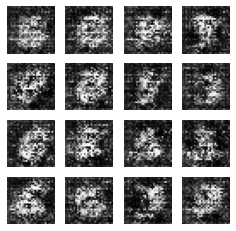

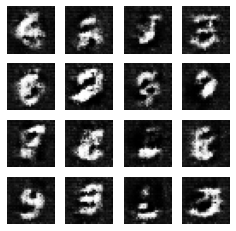

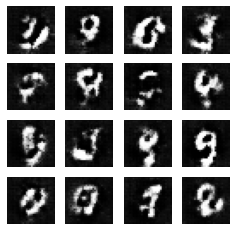

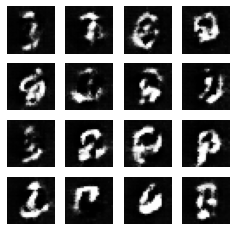

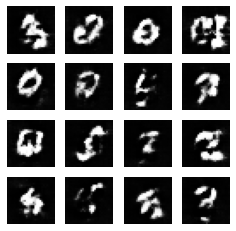

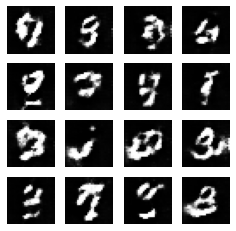

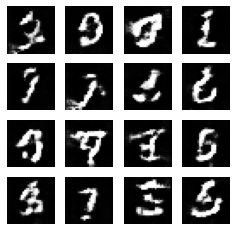

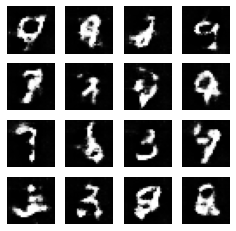

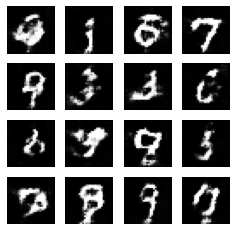

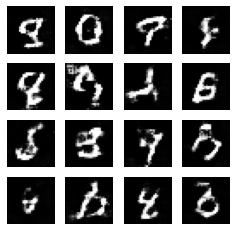

In [9]:
#執行模型
iterations = 10000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)